**Dataset description: PenFudanPed (University of Pennsylvania & Fudan University Pedestrian dataset)**:

This is an image database containing images that are used for pedestrian detection & the images are taken from scenes around campus and urban street. The objects we are interested in these images are pedestrians. Each image will have at least one pedestrian in it.

The heights of labeled pedestrians in this database fall into [180,390] pixels. All labeled pedestrians are straight up.

There are 170 images with 345 labeled pedestrians, among which 96 images are taken from around University of Pennsylvania, and other 74 are taken from around Fudan University.

*Note: The code is modified slightly from the [original version](https://www.kaggle.com/code/blossom1994/pedestrian-instance-segmentation-using-maskrcnn).*


# Importing and Installing libraries

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983 (from 1)
Receiving objects: 100% (983/983), 149.27 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (572/572), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.p

In [2]:
import os,sys
import pandas as pd
from PIL import Image
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
import numpy as np
import re


ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from matplotlib import pyplot
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [3]:
class PedDataset(Dataset):
    def load_dataset(self, dataset_dir='../input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed', mode='train'):
        # Add a class named 'pedestrian' with class ID 1
        self.add_class('dataset', 1, 'pedestrian')
        
        # Define directories for images, annotations, and masks
        images_dir = dataset_dir + '/PNGImages/'
        annotations_dir = dataset_dir + '/Annotation/'
        masks_dir = dataset_dir + '/PedMasks/'
        
        # Load dataset based on the mode (train or test)
        if mode == 'train':
            j = 0
            # Loop through image files in the training directory
            for filename in listdir(images_dir):
                j += 1
                if j > 150:
                    continue  # Skip images after the 150th one
                image_id = filename
                img_path = images_dir + image_id
                ann_path = annotations_dir + image_id[:-4] + '.txt'  # Remove the file extension and add '.txt'
                mask_path = masks_dir + image_id[:-4] + '_mask.png'  # Remove the file extension and add '_mask.png'
                # Add image information to the dataset
                self.add_image('dataset', image_id=image_id, path=img_path, ann_path=ann_path, mask_path=mask_path)
        
        if mode == 'test':
            j = 0
            # Loop through image files in the test directory
            for filename in listdir(images_dir):
                j += 1
                if j <= 150:
                    continue  # Skip images before the 150th one
                image_id = filename
                img_path = images_dir + image_id
                ann_path = annotations_dir + image_id[:-4] + '.txt'  # Remove the file extension and add '.txt'
                mask_path = masks_dir + image_id[:-4] + '_mask.png'  # Remove the file extension and add '_mask.png'
                # Add image information to the dataset
                self.add_image('dataset', image_id=image_id, path=img_path, ann_path=ann_path, mask_path=mask_path)
    
    def extract_boxes(self, image_id):
        # Extract bounding box coordinates from annotation file for a given image
        info = self.image_info[image_id]
        file_path = info['ann_path']
        boxes = []

        with open(file_path, 'r') as f:
            for line in f:
                # Match the bounding box format using regex
                match = re.search(r'\(Xmin, Ymin\) - \(Xmax, Ymax\): \((\d+), (\d+)\) - \((\d+), (\d+)\)', line)
                if match:
                    xmin, ymin, xmax, ymax = map(int, match.groups())
                    boxes.append([xmin, ymin, xmax, ymax])

        width = 559
        height = 536
        return boxes, width, height

    
    def load_mask(self, image_id):
        """
        Load binary masks for the objects in an image.

        Args:
            image_id (int): The ID of the image for which masks are to be loaded.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing:
                - masks (np.ndarray): A binary mask array of shape (height, width, num_objects).
                - class_ids (np.ndarray): An array of class IDs corresponding to each mask.
        """
        # Load image information
        info = self.image_info[image_id]
        file = info['mask_path']

        # Load the mask image
        masks = Image.open(file)
        masks = np.array(masks)  # Convert to numpy array

        # Get unique object IDs, excluding the background
        ob_id = np.unique(masks)[1:]  # Exclude background

        # Create binary masks for each object ID
        binary_masks = []
        for obj_id in ob_id:
            binary_mask = (masks == obj_id)  # Create a binary mask for the current object ID
            binary_masks.append(binary_mask)  # Append the binary mask to the list

        # Convert list of masks to a numpy array and move axes
        masks = np.array(binary_masks).transpose(1, 2, 0)  # Shape: (height, width, num_objects)

        # Assign class IDs for each mask (all pedestrians)
        class_ids = np.full(len(ob_id), self.class_names.index('pedestrian'), dtype='int32')
    
        return masks, class_ids
    
    def image_reference(self, image_id):
        # Return the path of the referenced image
        info = self.image_info[image_id]
        return info['path']

In [4]:
# Create an instance of PedDataset for the training set
train_set = PedDataset()
# Load the training dataset
train_set.load_dataset(mode='train')
# Prepare the training set, which includes preprocessing and organizing the data for training
train_set.prepare()
# Print the number of images in the training set
print('Train: %d' % len(train_set.image_ids))

# Create another instance of PedDataset for the test set
test_set = PedDataset()
# Load the test dataset
test_set.load_dataset(mode='test')
# Prepare the test set, similar to the training set
test_set.prepare()
# Print the number of images in the test set
print('Test: %d' % len(test_set.image_ids))

Train: 150
Test: 20


(341, 414, 3)
(341, 414, 2)


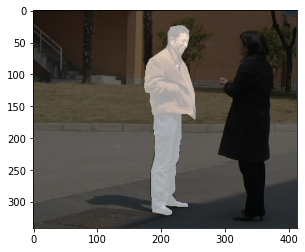

In [5]:
image_id = 8
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
pyplot.imshow(image)
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.6)
pyplot.show()

# Training

In [6]:
# Define configuration settings for pedestrian detection, including class names, training steps, validation steps,and image dimensions, and other parameters required for training Mask R-CNN.

class PedConfig(Config):
    NAME = "ped_cfg"
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 150
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 448
    
config = PedConfig()

In [7]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [8]:
#Create the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [9]:
#load model weights
model.load_weights('../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [10]:
#train the model
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=4, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./ped_cfg20241007T0914/mask_rcnn_ped_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrc

# Evaluation

In [11]:
# Define a configuration class PredictionConfig for making predictions with pedestrian detection models using Mask R-CNN.
# Specifies settings such as class names, number of classes, GPU count, images per GPU, and whether to use mini masks.

class PredictionConfig(Config):
    NAME = "all_data"
    NUM_CLASSES = 81
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

In [12]:
cfg = PredictionConfig() # Create an instance of PredictionConfig to configure prediction settings.
model = MaskRCNN(mode='inference', model_dir='./', config=cfg) # Instantiate a MaskRCNN model for inference using the provided configuration.

In [13]:
# Iterate through the contents of the current directory
for i in listdir():
    print(i)  # Print the name of the current item
    
    # Check if the first three characters of the item's name are 'ped'
    if i[:3] == 'ped':
        path = i  # If the condition is met, assign the item's name to the variable 'path'

ped_cfg20241007T0914
Mask_RCNN


In [14]:
model.load_weights('/kaggle/input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True)

In [15]:
def evaluate_model(dataset, model, cfg):
    # Initialize an empty list to store average precisions (APs)
    APs = list()
    
    # Counter to limit the number of evaluated images
    j = 0
    
    # Iterate through image IDs in the dataset
    for image_id in dataset.image_ids:
        # Limit the evaluation to 50 images
        if j > 50:
            continue  # Skip to the next image if the limit is reached
        
        # Load the image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        
        # Preprocess the image
        scaled_image = mold_image(image, cfg)
        
        # Expand the dimensions of the preprocessed image to match the model input shape
        sample = expand_dims(scaled_image, 0)
        
        # Perform object detection on the preprocessed image
        yhat = model.detect(sample, verbose=0)
        
        # Get the detection results
        r = yhat[0]
        
        # Compute average precision (AP) for the detected objects
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        # Append the computed AP to the list
        APs.append(AP)
        
        # Increment the counter
        j += 1
    
    # Calculate the mean average precision (mAP) over all evaluated images
    mAP = mean(APs)
    
    # Return the computed mAP
    return mAP

In [16]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.975
Test mAP: 0.985


In [17]:

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
len(class_names)

81

Processing 1 images
image                    shape: (343, 325, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


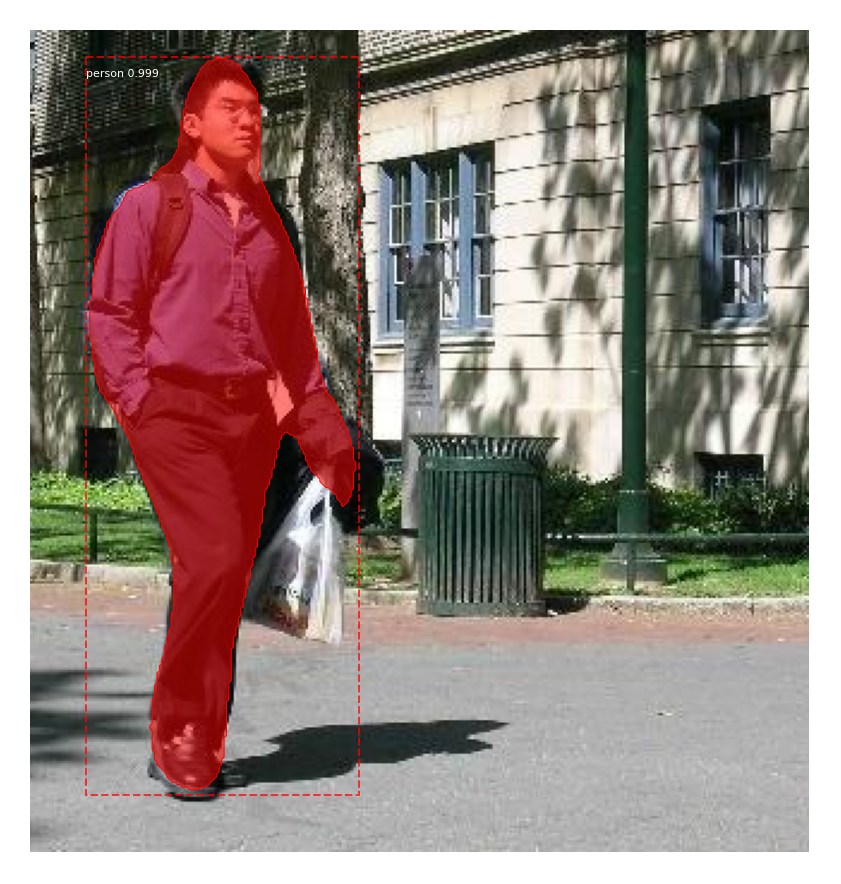

Processing 1 images
image                    shape: (486, 925, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


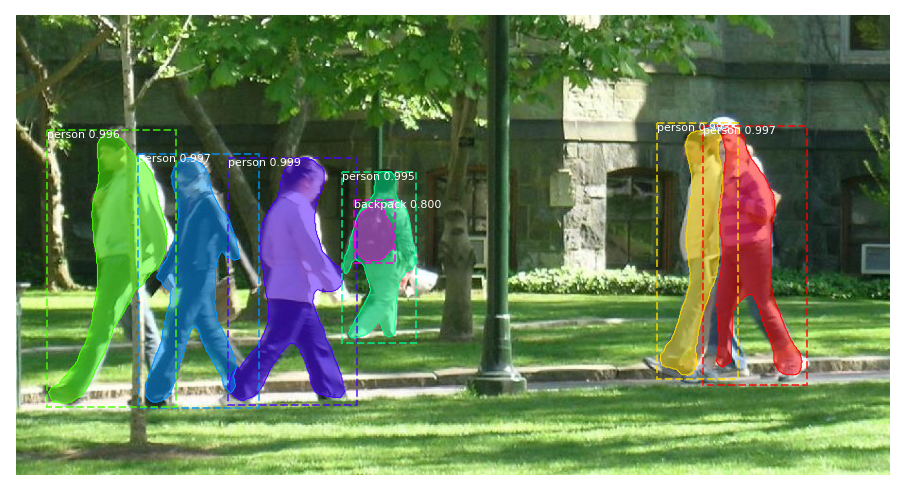

Processing 1 images
image                    shape: (348, 534, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


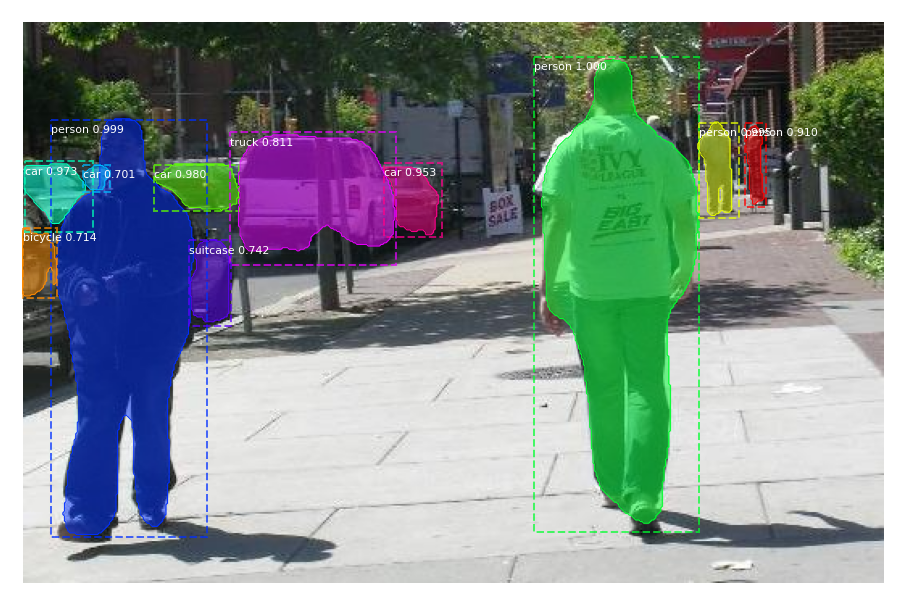

Processing 1 images
image                    shape: (525, 682, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


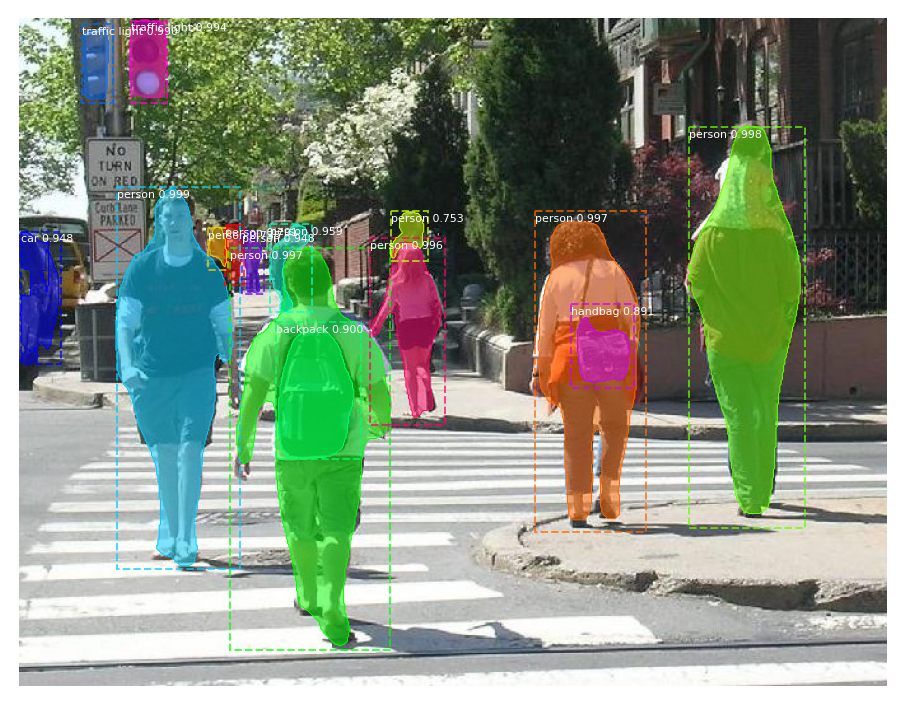

Processing 1 images
image                    shape: (411, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


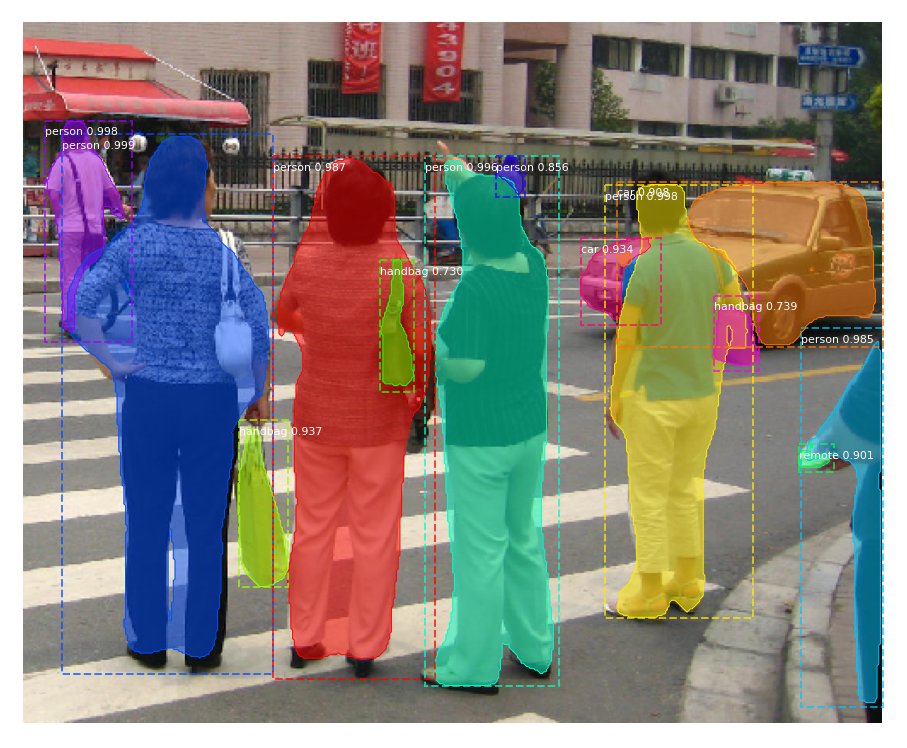

In [18]:
#displaying instances
#class_names = ['BG', 'pedestrian']
for i in range(5,10):
    image = test_set.load_image(i)
    results = model.detect([image], verbose=1)
    r = results[0]
    display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

--2024-10-07 09:21:36--  https://img.freepik.com/free-photo/positive-man-with-ice-cream-is-holding-hand-smiling-woman-brown-dress-romantic-couple-walking-with-big-labrador-park_197531-25675.jpg
Resolving img.freepik.com (img.freepik.com)... 2.18.121.27, 2.18.121.5, 2a02:26f0:1180:19::212:7905, ...
Connecting to img.freepik.com (img.freepik.com)|2.18.121.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106487 (104K) [image/jpeg]
Saving to: ‘positive-man-with-ice-cream-is-holding-hand-smiling-woman-brown-dress-romantic-couple-walking-with-big-labrador-park_197531-25675.jpg’

positive-man-with-i 100%[===================>] 103.99K  --.-KB/s    in 0.01s   

2024-10-07 09:21:36 (8.75 MB/s) - ‘positive-man-with-ice-cream-is-holding-hand-smiling-woman-brown-dress-romantic-couple-walking-with-big-labrador-park_197531-25675.jpg’ saved [106487/106487]

Image shape: (417, 626, 3)
Processing 1 images
image                    shape: (417, 626, 3)         min:    0.00000  

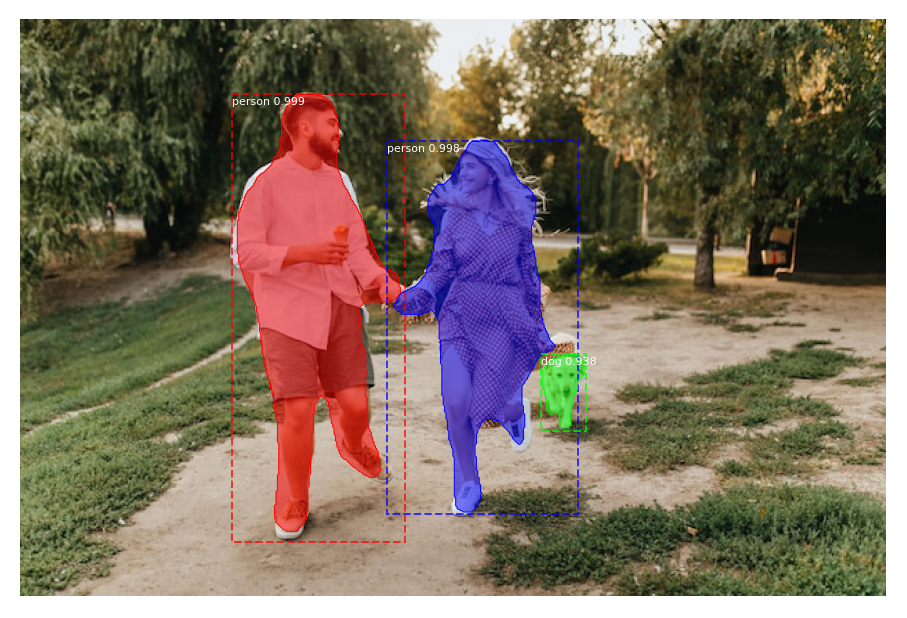

In [19]:
import skimage.io
import skimage

# Load the image from the specified path
!wget https://img.freepik.com/free-photo/positive-man-with-ice-cream-is-holding-hand-smiling-woman-brown-dress-romantic-couple-walking-with-big-labrador-park_197531-25675.jpg
path = '/kaggle/working/positive-man-with-ice-cream-is-holding-hand-smiling-woman-brown-dress-romantic-couple-walking-with-big-labrador-park_197531-25675.jpg'
image = skimage.io.imread(path)

# Ensure the image has the correct shape and format
if len(image.shape) == 2:
    # If the image is grayscale, convert it to RGB
    image = skimage.color.gray2rgb(image)
elif image.shape[-1] == 4:
    # If the image has an alpha channel, remove it
    image = image[..., :3]

# Check the shape of the image
print("Image shape:", image.shape)

# Perform object detection using the Mask R-CNN model
results = model.detect([image], verbose=1)
r = results[0]

# Display the detected instances
display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [20]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(417, 626, 3)

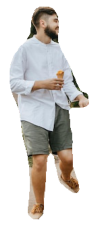

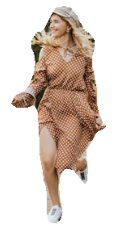

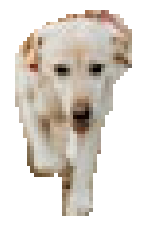

In [21]:
#You can invert the masks using:
#mask = 1-mask
import matplotlib.pyplot as plt

def segment(image, p, i):
    mask = p['masks'][:,:,i]
    bbox = p['rois'][i]
    mask = np.stack((mask,)*3, axis=-1)
    mask = mask.astype('uint8')
    bg = 255 - mask * 255
    mask_img = image*mask
    result = mask_img+ bg
    return result[bbox[0]:bbox[2], bbox[1]:bbox[3]]



for i in range(mask.shape[2]):
    segmentation = segment(image, r, i)
    fig=plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(segmentation)